<a href="https://colab.research.google.com/github/lmethratta/Poliscope/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install datasets transformers

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split

# Load dataset
!wget -O data.csv "https://raw.githubusercontent.com/lmethratta/Poliscope/refs/heads/main/twinviews-13k.csv"

# Load CSV into a DataFrame
df = pd.read_csv("data.csv")


--2025-04-14 22:19:52--  https://raw.githubusercontent.com/lmethratta/Poliscope/refs/heads/main/twinviews-13k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3063233 (2.9M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   2.92M  --.-KB/s    in 0.04s   

2025-04-14 22:19:52 (81.7 MB/s) - ‘data.csv’ saved [3063233/3063233]



In [20]:
# Create a regression dataset with scores from -1 to 1
df_left = df[['l']].rename(columns={'l': 'text'})
df_left['bias_score'] = -1  # Left bias

df_right = df[['r']].rename(columns={'r': 'text'})
df_right['bias_score'] = 1  # Right bias

# Combine datasets and shuffle
df_combined = pd.concat([df_left, df_right]).sample(frac=1).reset_index(drop=True)

# Split into train and validation
train_df, val_df = train_test_split(df_combined, test_size=0.1, random_state=42)

# Load pre-trained tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)


In [21]:
import numpy as np
from sklearn.metrics import average_precision_score

def average_precision_at_k(relevance_scores, k):
    """Computes Average Precision at K"""
    relevance_scores = np.array(relevance_scores)[:k]
    num_relevant = np.sum(relevance_scores)
    if num_relevant == 0:
        return 0.0
    cumulative_precision = [
        np.sum(relevance_scores[:i+1]) / (i+1) for i in range(len(relevance_scores))
    ]
    return np.sum(cumulative_precision * relevance_scores) / num_relevant

def mean_average_precision(relevance_scores_list, k=10):
    """Computes Mean Average Precision (MAP)"""
    return np.mean([average_precision_at_k(scores, k) for scores in relevance_scores_list])

def dcg_at_k(relevance_scores, k):
    """Computes Discounted Cumulative Gain at K"""
    relevance_scores = np.array(relevance_scores)[:k]
    return np.sum(relevance_scores / np.log2(np.arange(2, len(relevance_scores) + 2)))

def ndcg_at_k(relevance_scores, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG)"""
    ideal_relevance = sorted(relevance_scores, reverse=True)  # Ideal DCG
    return dcg_at_k(relevance_scores, k) / (dcg_at_k(ideal_relevance, k) + 1e-10)

# Example usage:
relevance_scores_list = [
    [1, 0, 1, 1, 0],  # Example query results: 1 = relevant, 0 = non-relevant
    [1, 1, 0, 0, 1],
]

map_score = mean_average_precision(relevance_scores_list, k=5)
ndcg_score = np.mean([ndcg_at_k(scores, k=5) for scores in relevance_scores_list])

print(f"MAP: {map_score:.4f}")
print(f"NDCG: {ndcg_score:.4f}")


MAP: 0.8361
NDCG: 0.9265


In [22]:
# Create torch datasets
class PoliticalBiasDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer):
        self.encodings = tokenizer(dataframe["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
        self.labels = torch.tensor(dataframe["bias_score"].values, dtype=torch.float32)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = PoliticalBiasDataset(train_df, tokenizer)
val_dataset = PoliticalBiasDataset(val_df, tokenizer)

In [23]:
# Load model for regression (1 output for the bias score)
# API Key: 22837c95f026f63e3b60016c1de298e170d484cd
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rombuski (rombuski-northeastern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Function to predict bias score for new text
def predict_bias(text, model, tokenizer, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Move model to the specified device
    model.to(device)

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Move input tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.logits.item()  # Returns a score between -1 and 1

# Example usage
test_texts = [
    "Abortion should be free",
    "Lower taxes and less regulation will stimulate economic growth.",
    "Healthcare should be a basic right for all citizens."
]


# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

for text in test_texts:
    score = predict_bias(text, model, tokenizer)
    print(f"Text: {text}")
    print(f"Bias score: {score:.2f}")
    print(f"Political leaning: {'Left' if score < 0 else 'Right'}")
    print("-" * 50)

Using device: cuda
Text: Abortion should be free
Bias score: -1.02
Political leaning: Left
--------------------------------------------------
Text: Lower taxes and less regulation will stimulate economic growth.
Bias score: 0.99
Political leaning: Right
--------------------------------------------------
Text: Healthcare should be a basic right for all citizens.
Bias score: -1.03
Political leaning: Left
--------------------------------------------------


In [ ]:
# def compute_accuracy(model, data_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     total_loss = 0
#     criterion = nn.MSELoss()

#     with torch.no_grad():
#         for inputs, labels in data_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             outputs = model(inputs).squeeze()

#             # Convert regression output to -1 or 1
#             predictions = torch.where(outputs >= 0, torch.tensor(1.0, device=device), torch.tensor(-1.0, device=device))

#             correct += (predictions == labels).sum().item()
#             total += labels.size(0)

#             loss = criterion(outputs, labels)
#             total_loss += loss.item()

#     accuracy = correct / total * 100
#     return total_loss / len(data_loader), accuracy


# # Compute validation loss & accuracy
# val_loss, val_accuracy = compute_accuracy(model, val_loader)
# print(f"Validation Loss: {val_loss:.4f}")
# print(f"Validation Accuracy: {val_accuracy:.2f}%")

In [ ]:
# === Part 1: Logistic Regression Classifier on TF-IDF ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# For demonstration, assume df_combined is already defined and contains columns 'text' and 'bias_score'
# Create a binary label: left bias (<0) maps to 0 and right bias (>=0) maps to 1.
df_combined['binary_label'] = df_combined['bias_score'].apply(lambda x: 0 if x < 0 else 1)

# Split the data into train and validation sets
train_df_lr, val_df_lr = train_test_split(df_combined, test_size=0.1, random_state=42)

# Initialize the TF-IDF vectorizer (this lowercases text and removes English stopwords)
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X_train = vectorizer.fit_transform(train_df_lr['text'])
X_val = vectorizer.transform(val_df_lr['text'])
y_train = train_df_lr['binary_label']
y_val = val_df_lr['binary_label']  # Use the validation labels here!

# Train the logistic regression classifier
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)

# Predict and evaluate on the validation set
y_pred = lr_model.predict(X_val)
print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_pred))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1374
           1       0.96      0.97      0.97      1397

    accuracy                           0.97      2771
   macro avg       0.97      0.97      0.97      2771
weighted avg       0.97      0.97      0.97      2771



Confusion Matrix:
[[1321   53]
 [  36 1361]]


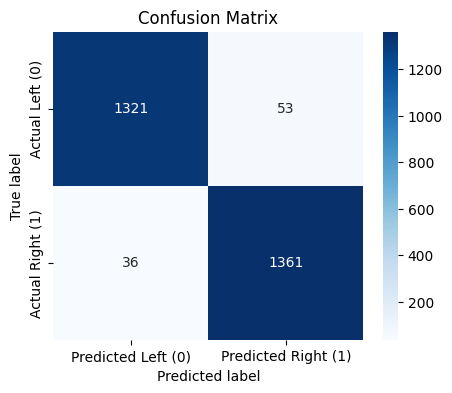

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Print out the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can also plot the confusion matrix for a visual perspective:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Left (0)", "Predicted Right (1)"],
            yticklabels=["Actual Left (0)", "Actual Right (1)"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# === Part 2: BM25 Relevance Scoring ===
# Install rank_bm25 if needed
!pip install rank_bm25

import re
import numpy as np
from rank_bm25 import BM25Okapi

# Define a simple preprocessing function to remove punctuation and lowercase the text
def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text.split()

# Build the BM25 corpus: tokenize each document in df_combined
corpus = [preprocess(doc) for doc in df_combined['text']]
bm25 = BM25Okapi(corpus)

# For a sample query, preprocess it similarly:
query = "healthcare for all citizens"
query_tokens = preprocess(query)

# Calculate BM25 relevance scores for each document in the corpus
relevance_scores = bm25.get_scores(query_tokens)
print("BM25 relevance scores computed.")

BM25 relevance scores computed.


In [ ]:
# === Part 3: Combine Bias Confidence Scores and BM25 Scores for Ranking ===
# Get the bias confidence scores from the logistic regression classifier:
# Transform all documents using the TF-IDF vectorizer.
X_full = vectorizer.transform(df_combined['text'])
# Predict the probability of class '1' (right bias)
predicted_probas = lr_model.predict_proba(X_full)[:, 1]

# Map probabilities from [0, 1] to a signed bias score in [-1, 1]
bias_scores = 2 * predicted_probas - 1

# Convert relevance_scores to a NumPy array if it isn't already
relevance_scores = np.array(relevance_scores)

# Combine the scores (here we use multiplication as an example)
final_scores = relevance_scores * bias_scores

# Rank documents based on the combined final score (descending order)
ranked_indices = np.argsort(final_scores)[::-1]

# Display the top 10 ranked documents
print("\nTop 10 Ranked Documents:")
for i, idx in enumerate(ranked_indices[:10], start=1):
    doc_text = df_combined.iloc[idx]['text'][:100].replace('\n', ' ')  # show first 100 characters
    print(f"{i}. Score: {final_scores[idx]:.4f} | Excerpt: {doc_text}...")


Top 10 Ranked Documents:
1. Score: 8.2660 | Excerpt: Citizens should be responsible for their own healthcare costs....
2. Score: 8.1507 | Excerpt: Lowering taxes for all promotes economic growth, incentivizes investment, and benefits all citizens....
3. Score: 7.8075 | Excerpt: Lower taxes for everyone stimulate economic growth and benefit all citizens...
4. Score: 7.2539 | Excerpt: Free-market competition leads to innovation and affordable healthcare options for all....
5. Score: 6.8919 | Excerpt: Free market competition leads to innovation and improves healthcare outcomes for all....
6. Score: 6.8874 | Excerpt: Lowering taxes for the wealthy stimulates economic growth and benefits all citizens....
7. Score: 6.7561 | Excerpt: Tax cuts for businesses and the wealthy stimulate economic growth and benefit all citizens....
8. Score: 6.7025 | Excerpt: Lower taxes for the wealthy incentivize investment, job creation, and economic growth that benefits ...
9. Score: 6.6848 | Excerpt: Lower t

In [ ]:
import numpy as np

def average_precision_at_k(relevance_scores, k):
    """Compute Average Precision at K for one query."""
    relevance_scores = np.array(relevance_scores)[:k]
    num_relevant = np.sum(relevance_scores)
    if num_relevant == 0:
        return 0.0
    cumulative_precision = [
        np.sum(relevance_scores[:i+1]) / (i+1) for i in range(len(relevance_scores))
    ]
    return np.sum(cumulative_precision * relevance_scores) / num_relevant

def mean_average_precision(relevance_scores_list, k=10):
    """Compute Mean Average Precision over multiple queries."""
    return np.mean([average_precision_at_k(scores, k) for scores in relevance_scores_list])

def dcg_at_k(relevance_scores, k):
    """Compute Discounted Cumulative Gain at K."""
    relevance_scores = np.array(relevance_scores)[:k]
    return np.sum(relevance_scores / np.log2(np.arange(2, len(relevance_scores) + 2)))

def ndcg_at_k(relevance_scores, k):
    """Compute Normalized Discounted Cumulative Gain at K."""
    ideal_relevance = sorted(relevance_scores, reverse=True)  # highest scores first
    return dcg_at_k(relevance_scores, k) / (dcg_at_k(ideal_relevance, k) + 1e-10)


# === Sample Evaluation ===
# For demonstration, suppose we have a list of queries.
sample_queries = [
    "healthcare for all citizens",
    "tax cuts for economic growth",
    "environmental policy and climate change"
]

# Here we define a helper function to get final ranking scores
# using a combination strategy. This example assumes
# we already have a BM25 instance (`bm25`), a trained TF-IDF vectorizer,
# and a trained logistic regression model `lr_model`.

def get_final_scores(query, combination_strategy='multiplicative', alpha=0.5, beta=0.5):
    """
    Compute final ranking scores for the entire corpus given a query.

    Parameters:
    - query: str, the search query.
    - combination_strategy: string, one of 'multiplicative', 'additive', or 'weighted'.
    - alpha, beta: weights for the weighted sum combination.

    Returns:
    - final_scores: NumPy array of combined scores for each document.
    """
    # Preprocess and compute BM25 scores for the query
    query_tokens = preprocess(query)
    bm25_scores = np.array(bm25.get_scores(query_tokens))

    # Obtain bias confidence scores using the logistic regression classifier.
    X_full = vectorizer.transform(df_combined['text'])
    predicted_probas = lr_model.predict_proba(X_full)[:, 1]
    # Map [0, 1] probability to [-1, 1]
    bias_scores = 2 * predicted_probas - 1

    if combination_strategy == 'multiplicative':
        final_scores = bm25_scores * bias_scores
    elif combination_strategy == 'additive':
        final_scores = bm25_scores + bias_scores
    elif combination_strategy == 'weighted':
        # You can adjust alpha and beta to weight the relevance and bias scores
        final_scores = alpha * bm25_scores + beta * bias_scores
    else:
        raise ValueError("Invalid combination strategy provided.")

    return final_scores


# Assume we have some dummy ground truth relevance judgments for these queries.
# For each query, create a list of relevance labels (1 for relevant, 0 for non-relevant).
# In practice, replace these with your actual judgments.
dummy_judgments = {
    "healthcare for all citizens": [1 if i % 5 == 0 else 0 for i in range(len(df_combined))],
    "tax cuts for economic growth": [1 if i % 7 == 0 else 0 for i in range(len(df_combined))],
    "environmental policy and climate change": [1 if i % 11 == 0 else 0 for i in range(len(df_combined))]
}

# Evaluate each query
map_scores = []
ndcg_scores = []
k = 10  # Evaluate MAP@10 and NDCG@10

for query in sample_queries:
    final_scores = get_final_scores(query, combination_strategy='multiplicative')
    ranked_indices = np.argsort(final_scores)[::-1]

    # Generate the relevance list for the ranked order
    ranked_relevances = [dummy_judgments[query][idx] for idx in ranked_indices]

    ap = average_precision_at_k(ranked_relevances, k)
    ndcg = ndcg_at_k(ranked_relevances, k)
    map_scores.append(ap)
    ndcg_scores.append(ndcg)

    print(f"Query: '{query}'")
    print(f"MAP@{k}: {ap:.4f}, NDCG@{k}: {ndcg:.4f}\n")

print(f"Mean MAP@{k}: {np.mean(map_scores):.4f}")
print(f"Mean NDCG@{k}: {np.mean(ndcg_scores):.4f}")


Query: 'healthcare for all citizens'
MAP@10: 0.2250, NDCG@10: 0.1584

Query: 'tax cuts for economic growth'
MAP@10: 0.1000, NDCG@10: 0.0636

Query: 'environmental policy and climate change'
MAP@10: 0.0000, NDCG@10: 0.0000

Mean MAP@10: 0.1083
Mean NDCG@10: 0.0740


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a pipeline that first vectorizes and then applies logistic regression.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True, stop_words='english')),
    ('lr', LogisticRegression(max_iter=200))
])

# Define a parameter grid for hyperparameter tuning.
param_grid = {
    'tfidf__max_features': [None, 5000, 10000],
    'lr__C': [0.1, 1, 10],
    'lr__solver': ['lbfgs', 'liblinear']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_df_lr['text'], train_df_lr['binary_label'])

print("Best parameters found:")
print(grid_search.best_params_)
print("Best training accuracy:")
print(grid_search.best_score_)

# Use the best estimator for prediction on the validation set:
best_model = grid_search.best_estimator_
y_pred_gs = best_model.predict(val_df_lr['text'])
print("Classification Report for Best Model:")
print(classification_report(val_df_lr['binary_label'], y_pred_gs))


Best parameters found:
{'lr__C': 10, 'lr__solver': 'liblinear', 'tfidf__max_features': None}
Best training accuracy:
0.9792293195396767
Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1374
           1       0.97      0.97      0.97      1397

    accuracy                           0.97      2771
   macro avg       0.97      0.97      0.97      2771
weighted avg       0.97      0.97      0.97      2771



In [ ]:
# Example: Use weighted sum combination with alpha=0.6 (BM25 weight) and beta=0.4 (bias weight)
final_scores_weighted = get_final_scores("healthcare for all citizens", combination_strategy='weighted', alpha=0.6, beta=0.4)
ranked_indices_weighted = np.argsort(final_scores_weighted)[::-1]

print("\nTop 10 Ranked Documents using Weighted Sum Combination:")
for i, idx in enumerate(ranked_indices_weighted[:10], start=1):
    doc_text = df_combined.iloc[idx]['text'][:100].replace('\n', ' ')
    print(f"{i}. Score: {final_scores_weighted[idx]:.4f} | Excerpt: {doc_text}...")



Top 10 Ranked Documents using Weighted Sum Combination:
1. Score: 7.5625 | Excerpt: Universal healthcare guarantees access to healthcare for all citizens....
2. Score: 7.5419 | Excerpt: Government-funded healthcare ensures access to healthcare for all citizens....
3. Score: 7.4485 | Excerpt: Government-funded healthcare leads to better healthcare outcomes for all citizens....
4. Score: 7.4394 | Excerpt: Universal healthcare leads to better healthcare outcomes for all citizens....
5. Score: 7.2844 | Excerpt: Universal healthcare ensures access to quality healthcare for all citizens....
6. Score: 7.2844 | Excerpt: Universal healthcare ensures access to quality healthcare for all citizens....
7. Score: 7.1960 | Excerpt: We should have universal healthcare for all citizens....
8. Score: 7.1483 | Excerpt: We should provide free healthcare for all citizens....
9. Score: 7.1483 | Excerpt: We should provide free healthcare for all citizens....
10. Score: 7.1477 | Excerpt: Universal healthcare

In [ ]:
# For each sample query, print the top 10 ranked documents along with their BM25, bias, and final scores.
def analyze_query(query, combination_strategy='multiplicative'):
    query_tokens = preprocess(query)
    bm25_scores = np.array(bm25.get_scores(query_tokens))

    X_full = vectorizer.transform(df_combined['text'])
    predicted_probas = lr_model.predict_proba(X_full)[:, 1]
    bias_scores = 2 * predicted_probas - 1

    if combination_strategy == 'multiplicative':
        final_scores = bm25_scores * bias_scores
    elif combination_strategy == 'additive':
        final_scores = bm25_scores + bias_scores
    elif combination_strategy == 'weighted':
        final_scores = 0.6 * bm25_scores + 0.4 * bias_scores
    else:
        raise ValueError("Invalid combination strategy.")

    ranked_indices = np.argsort(final_scores)[::-1]
    print(f"\nAnalysis for Query: '{query}'")
    print("{:<4} {:<10} {:<10} {:<10} {:<}".format("Rank", "BM25", "Bias", "Final", "Text Excerpt"))
    for i, idx in enumerate(ranked_indices[:10], start=1):
        bm25_sc = bm25_scores[idx]
        bias_sc = bias_scores[idx]
        final_sc = final_scores[idx]
        text_excerpt = df_combined.iloc[idx]['text'][:80].replace('\n', ' ')
        print(f"{i:<4} {bm25_sc:<10.4f} {bias_sc:<10.4f} {final_sc:<10.4f} {text_excerpt}")

# Analyze one of the sample queries
analyze_query("tax cuts for economic growth", combination_strategy='weighted')



Analysis for Query: 'tax cuts for economic growth'
Rank BM25       Bias       Final      Text Excerpt
1    20.0596    0.7882     12.3510    Tax cuts for the wealthy stimulate economic growth.
2    17.9310    0.8101     11.0827    Tax cuts for the wealthy stimulate economic growth and incentivize investment.
3    17.9310    0.8067     11.0813    Tax cuts for the wealthy stimulate economic growth and benefit everyone.
4    17.9310    0.8067     11.0813    Tax cuts for the wealthy stimulate economic growth and benefit everyone
5    17.9310    0.8067     11.0813    Tax cuts for the wealthy stimulate economic growth and benefit everyone.
6    17.3185    0.9244     10.7608    Tax cuts for the wealthy encourage investment, job creation, and economic growth
7    17.3185    0.9010     10.7515    Tax cuts for the wealthy stimulate economic growth and incentivize job creation.
8    16.7464    0.7099     10.3318    Tax cuts for the wealthy stimulate economic growth and benefit all income levels
9